In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

signal_folder = 'rpm_vib'

signal_files = [f for f in os.listdir(signal_folder) if f.endswith('.csv')]

signals = {}
for file in signal_files:
    file_path = os.path.join(signal_folder, file)
    data = pd.read_csv(file_path, header=None)
    signal = data.values.flatten()
    signals[file] = signal


In [29]:

def stft_custom(signal, sample_rate, window_ms=40, overlap_pct=0.5, use_hamming=False):
    window_size = int(window_ms * sample_rate / 1000)
    hop_size = int(window_size * (1 - overlap_pct))
    
    # Zero-padding to ensure full frames
    total_frames = int(np.ceil((len(signal) - window_size) / hop_size)) + 1
    pad_length = (total_frames - 1) * hop_size + window_size
    padded_signal = np.pad(signal, (0, pad_length - len(signal)))
    
    # Optional window function
    window = np.hamming(window_size) if use_hamming else np.ones(window_size)
    
    # STFT computation
    spectrogram = []
    for start in range(0, len(padded_signal) - window_size + 1, hop_size):
        frame = padded_signal[start:start + window_size] * window
        spectrum = np.fft.rfft(frame)  # Real FFT
        magnitude = np.abs(spectrum)
        spectrogram.append(magnitude)
    
    return np.array(spectrogram).T  # transpose to shape (freqs x frames)

Loaded 3 signals.


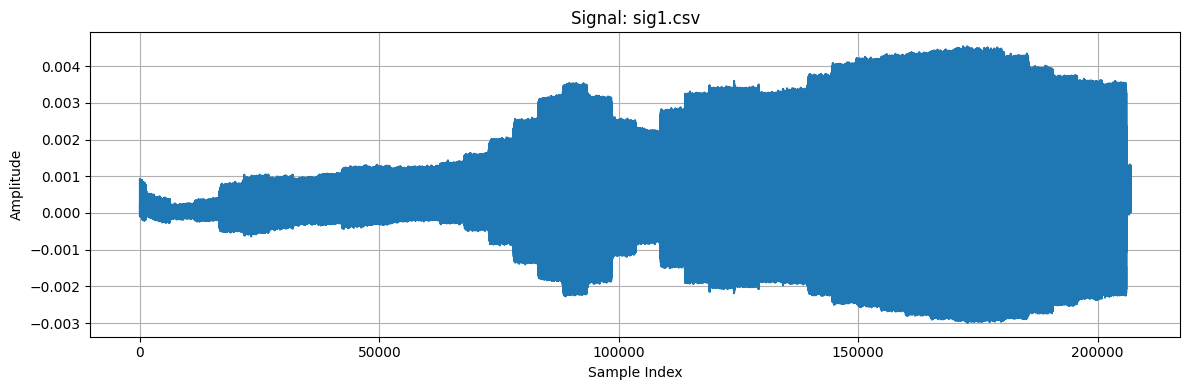

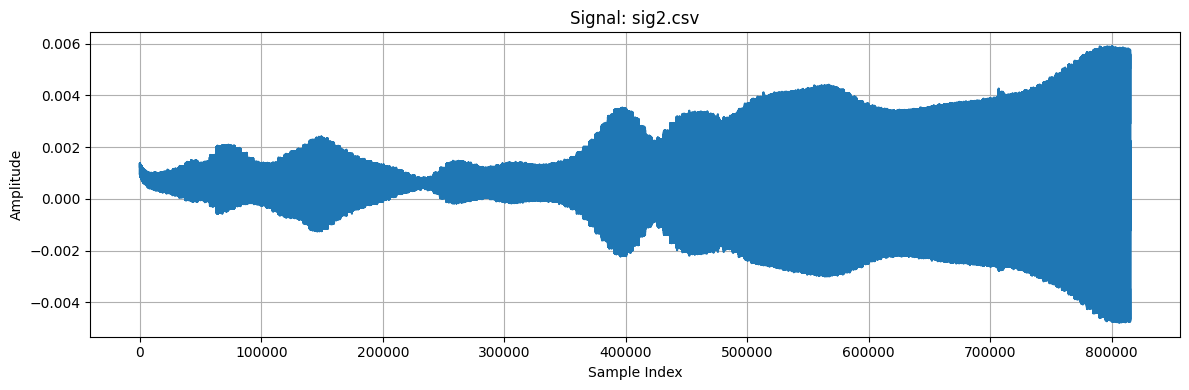

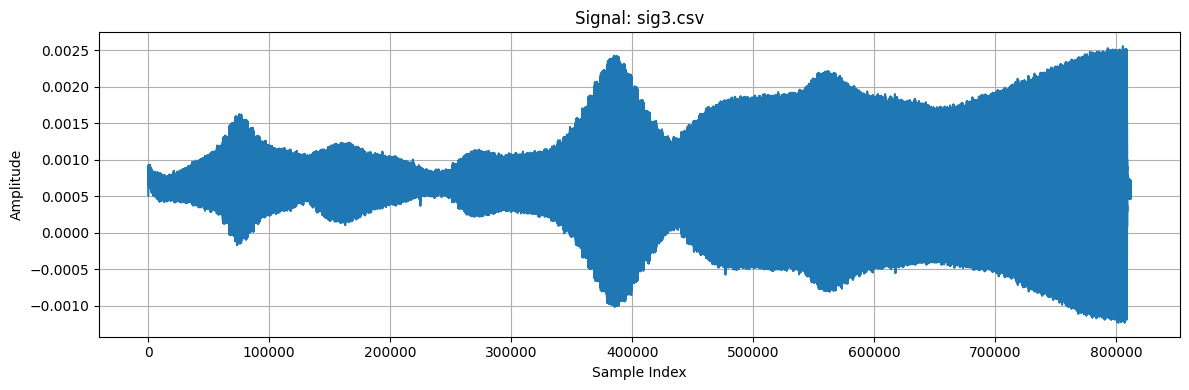

In [30]:
print(f"Loaded {len(signals)} signals.")

# Step 4: Visualize first 3 signals in separate charts
for i, (filename, signal) in enumerate(signals.items()):
    if i >= 3:
        break
    plt.figure(figsize=(12, 4))
    plt.plot(signal)
    plt.title(f"Signal: {filename}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [59]:
def estimate_rpm_from_stft(signal, sr, key, window_ms=1500, overlap_pct=0.75, freq_limit=50, time_points=10):
    # Remove DC offset from the signal
    signal = signal - np.mean(signal)
    
    # Compute STFT with Hamming window
    spec = stft_custom(signal, sr, window_ms, overlap_pct, use_hamming=True)
    spec_mag = np.abs(spec)

    n_frames = spec_mag.shape[1]
    frame_hop = int((1 - overlap_pct) * window_ms * sr / 1000)
    frame_times = np.arange(n_frames) * frame_hop / sr
    freqs = np.fft.rfftfreq(int(window_ms * sr / 1000), d=1/sr)

    # Limit frequency range
    freq_indices = freqs <= freq_limit
    freqs = freqs[freq_indices]
    spec_mag = spec_mag[freq_indices, :]

    # Pick equally spaced time points (frame indices)
    margin = int(spec_mag.shape[1] * 0.1)  # skip 10% on both sides
    selected_frames = np.linspace(margin, spec_mag.shape[1] - margin - 1, time_points, dtype=int)

    estimated_rpms = []
    for frame_idx in selected_frames:
        frame_magnitude = spec_mag[:, frame_idx]
        if np.max(frame_magnitude) < 1e-3:
            continue  # Skip frame if too weak
        dominant_freq = freqs[np.argmax(frame_magnitude)]
        if dominant_freq < 1e-3:  # still avoid any near-zero freq
            continue
        rpm = dominant_freq * 60
        estimated_rpms.append((frame_times[frame_idx], rpm))

    # Plot STFT with points
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(frame_times, freqs, spec_mag, shading='auto', cmap='magma')
    plt.colorbar(label="Amplitude")
    plt.title(f"STFT with RPM estimates – {key}")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim(0, freq_limit)

    for t, rpm in estimated_rpms:
        plt.axvline(x=t, color='cyan', linestyle='--', alpha=0.6)
        plt.text(t, freq_limit * 0.95, f"{int(rpm)} RPM", rotation=90,
                 color='white', ha='right', va='top', fontsize=9, backgroundcolor='black')

    plt.tight_layout()
    plt.show()

    return estimated_rpms



Estimating RPM for signal: sig1.csv


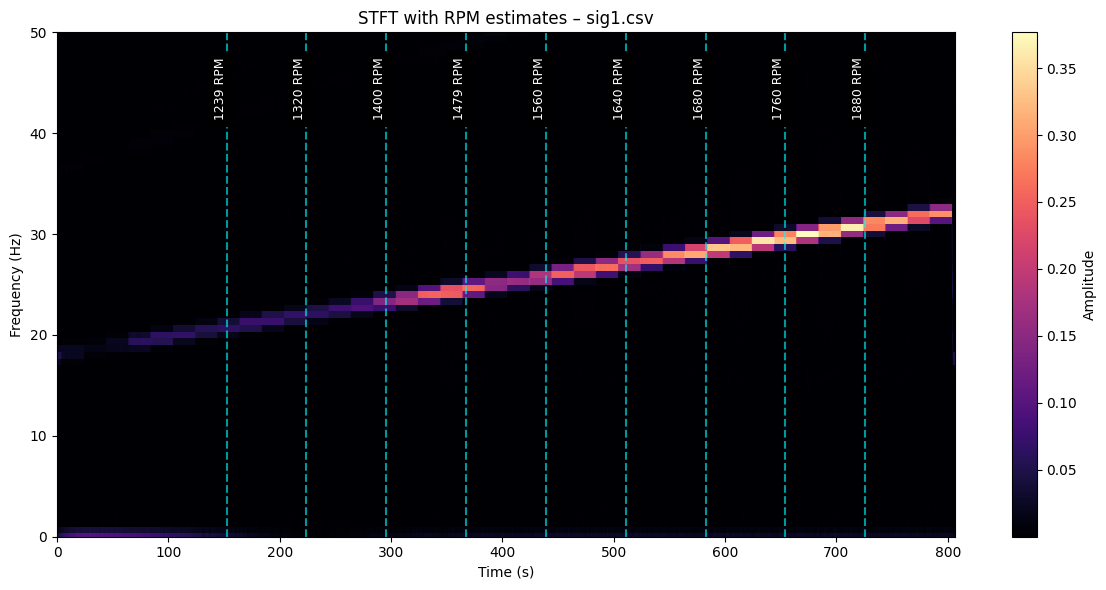

  Time: 152.25 s → Estimated RPM: 1240.0
  Time: 223.88 s → Estimated RPM: 1320.0
  Time: 295.50 s → Estimated RPM: 1400.0
  Time: 367.12 s → Estimated RPM: 1480.0
  Time: 439.12 s → Estimated RPM: 1560.0
  Time: 510.75 s → Estimated RPM: 1640.0
  Time: 582.38 s → Estimated RPM: 1680.0
  Time: 654.00 s → Estimated RPM: 1760.0
  Time: 726.00 s → Estimated RPM: 1880.0

Estimating RPM for signal: sig2.csv


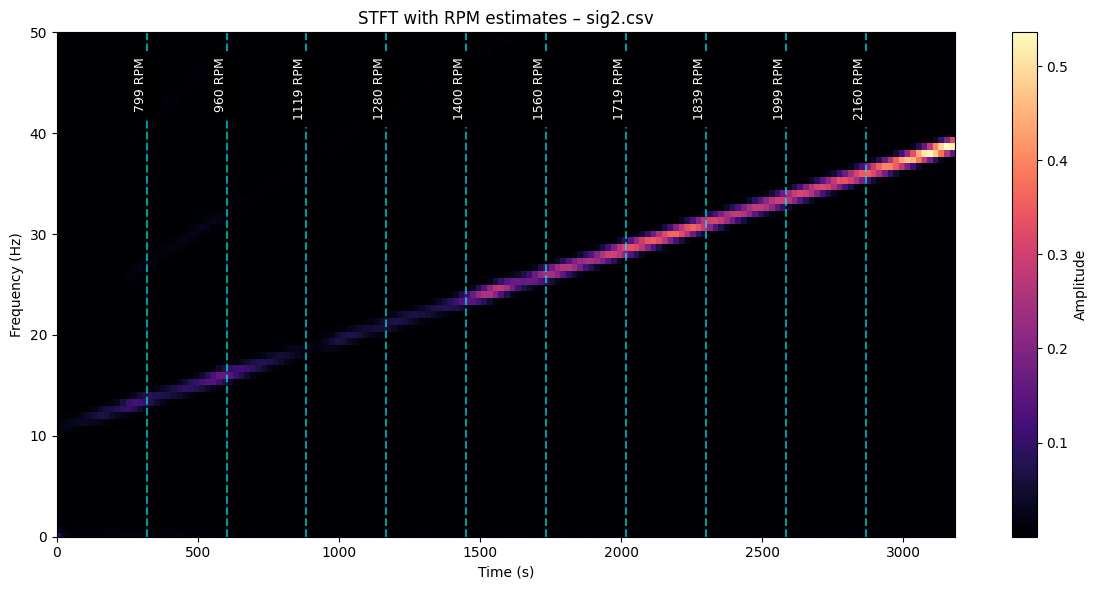

  Time: 318.38 s → Estimated RPM: 800.0
  Time: 601.12 s → Estimated RPM: 960.0
  Time: 884.25 s → Estimated RPM: 1120.0
  Time: 1167.38 s → Estimated RPM: 1280.0
  Time: 1450.50 s → Estimated RPM: 1400.0
  Time: 1733.25 s → Estimated RPM: 1560.0
  Time: 2016.38 s → Estimated RPM: 1720.0
  Time: 2299.50 s → Estimated RPM: 1840.0
  Time: 2582.62 s → Estimated RPM: 2000.0
  Time: 2865.75 s → Estimated RPM: 2160.0

Estimating RPM for signal: sig3.csv


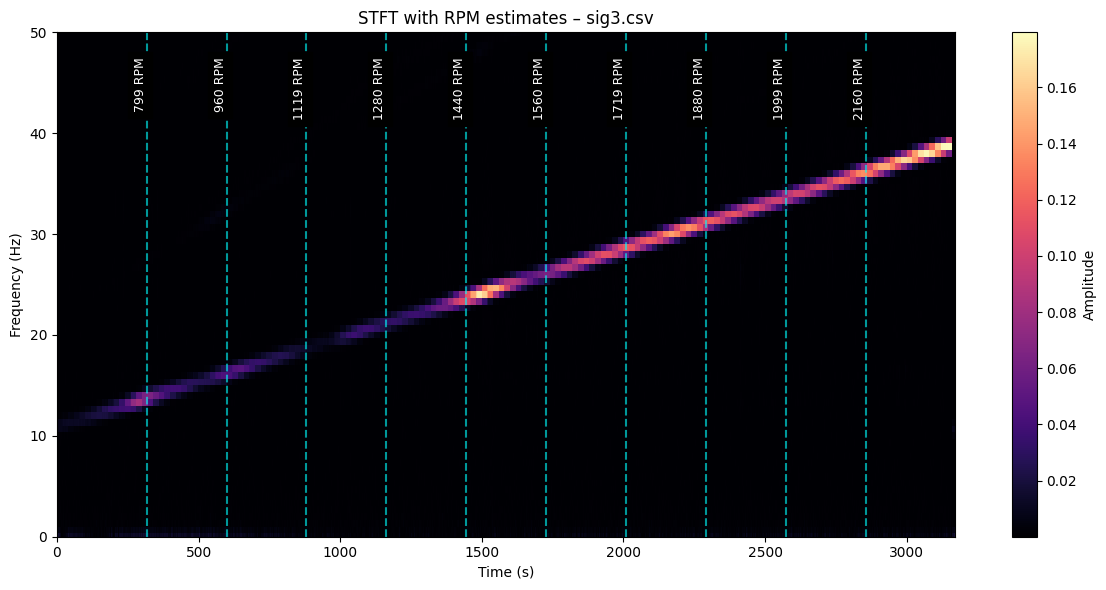

  Time: 316.88 s → Estimated RPM: 800.0
  Time: 598.88 s → Estimated RPM: 960.0
  Time: 880.88 s → Estimated RPM: 1120.0
  Time: 1162.88 s → Estimated RPM: 1280.0
  Time: 1444.88 s → Estimated RPM: 1440.0
  Time: 1726.88 s → Estimated RPM: 1560.0
  Time: 2008.88 s → Estimated RPM: 1720.0
  Time: 2290.88 s → Estimated RPM: 1880.0
  Time: 2572.88 s → Estimated RPM: 2000.0
  Time: 2854.88 s → Estimated RPM: 2160.0


In [60]:
sr = 256  # Sampling rate in Hz
for i, (filename, signal) in enumerate(signals.items()):
    if i >= 3:
        break
    print(f"\nEstimating RPM for signal: {filename}")
    rpms = estimate_rpm_from_stft(signal, sr, filename)
    for t, rpm in rpms:
        print(f"  Time: {t:.2f} s → Estimated RPM: {rpm:.1f}")
